In [194]:
using LowRankModels
using PyPlot
using CSV
using ProgressMeter
using Statistics
using LaTeXStrings
using Printf
using ScikitLearn.CrossValidation: KFold

# Load Henry coefficient matrix `H`

see `xxx.ipynb` for Python code that queries the NIST database for the adsorption data and fits Henry's law to the adsorption data to identify the Henry constant.

the gases run along the columns, the materials run along the rows, and the entries are the Henry coefficients identified from experimental adsorption data.

In [195]:
henry_df = CSV.read(joinpath("..", "data", "henry_matrix_df_l_4_nokeys.csv"))
H = convert(Array{Union{Float64, Missing}, 2}, henry_df[1:end, 2:end]) # the H matrix!

nm = size(H)[1] # no. of materials
ng = size(H)[2] # no. of gases

materials = String.(henry_df[:, 1]) # list of materials, order corresponding to rows in H
gases = String.(names(henry_df)[2:end]) # list of gases, order corresponding to cols in H
@assert length(materials) == nm && length(gases) == ng

## sort rows, cols according to the number of observations
... and sort `materials` and `gases` accordingly!

In [196]:
function sort_rows_cols_acc_to_nb_obs!(H::Array{Union{Float64, Missing}, 2}, 
                                       materials::Array{String, 1}, 
                                       gases::Array{String, 1})
    # rows
    nb_obs = [sum(.! ismissing.(H[i, :])) for i = 1:nm]
    ids_reorder = sortperm(nb_obs, rev=true)
    H .= H[ids_reorder, :]
    materials .= materials[ids_reorder]

    # cols
    nb_obs = [sum(.! ismissing.(H[:, j])) for j = 1:ng]
    ids_reorder = sortperm(nb_obs, rev=true)
    H .= H[:, ids_reorder]
    gases .= gases[ids_reorder]

    # sanity check
    @assert sum(ismissing.(H[:, 1])) < sum(ismissing.(H[:, 5])) # first row has fewer missing values
    @assert sum(ismissing.(H[1, :])) < sum(ismissing.(H[5, :])) # first col has fewer missing values
    return nothing
end

sort_rows_cols_acc_to_nb_obs!(H, materials, gases)

## prune matrix by selecting rows/cols with the most observations

In [197]:
nm = 20
ng = 10

H = H[1:nm, 1:ng]
materials = materials[1:nm]
gases = gases[1:ng];

sort_rows_cols_acc_to_nb_obs!(H, materials, gases)
println("min # observations in a row: ", sum(.! ismissing.(H[end, :])))
println("min # observations in a col: ", sum(.! ismissing.(H[:, end])))
# TODO copy Arni's code for viz of frequency of observations gases and mofs

min # observations in a row: 4
min # observations in a col: 7


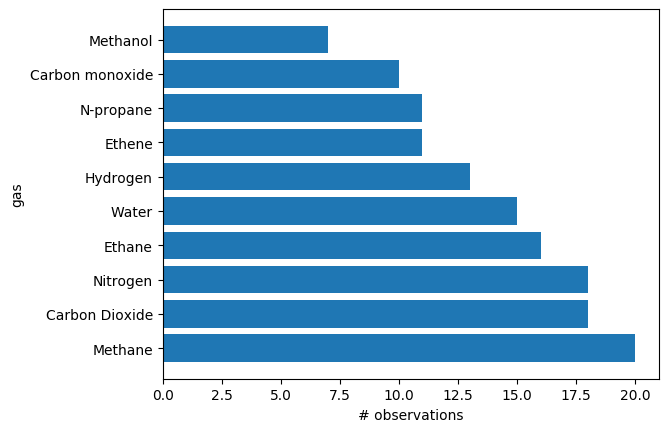

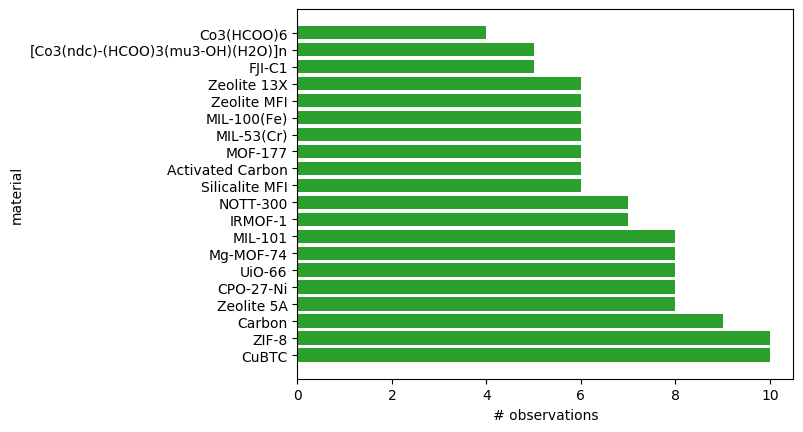

PyObject Text(24.000000000000043, 0.5, 'material')

In [198]:
plt.figure()
barh(gases, [sum(.! ismissing.(H[:, j])) for j = 1:ng])
xlabel("# observations")
ylabel("gas")

plt.figure()
barh(materials, [sum(.! ismissing.(H[i, :])) for i = 1:nm], color="C2")
xlabel("# observations")
ylabel("material")

## standardize columns, log10-transform
* take the `log` (base 10) to learn the *order of magnitude* of the Henry coefficients
* standardize the columns (representing $H$'s for a certain gas) so that each column has mean zero and variance of one

In [199]:
# log-10 transform
H = log10.(H)

# standardize the columns
for j = 1:ng
    # find ids that are not missing
    ids = .! ismissing.(H[:, j])
    # Hij <-- (Hij - μ_j) / σ_j 
    H[:, j] .= (H[:, j] .- mean(H[ids, j])) ./ std(H[ids, j])
end
# Udell ?: does it make sense to normalizes gases but not MOFs? 
#  Cory's justification: gases exhibit tons of variance in the means

## visualize

here, a diverging colormap is appropriate since the columns are standardized.

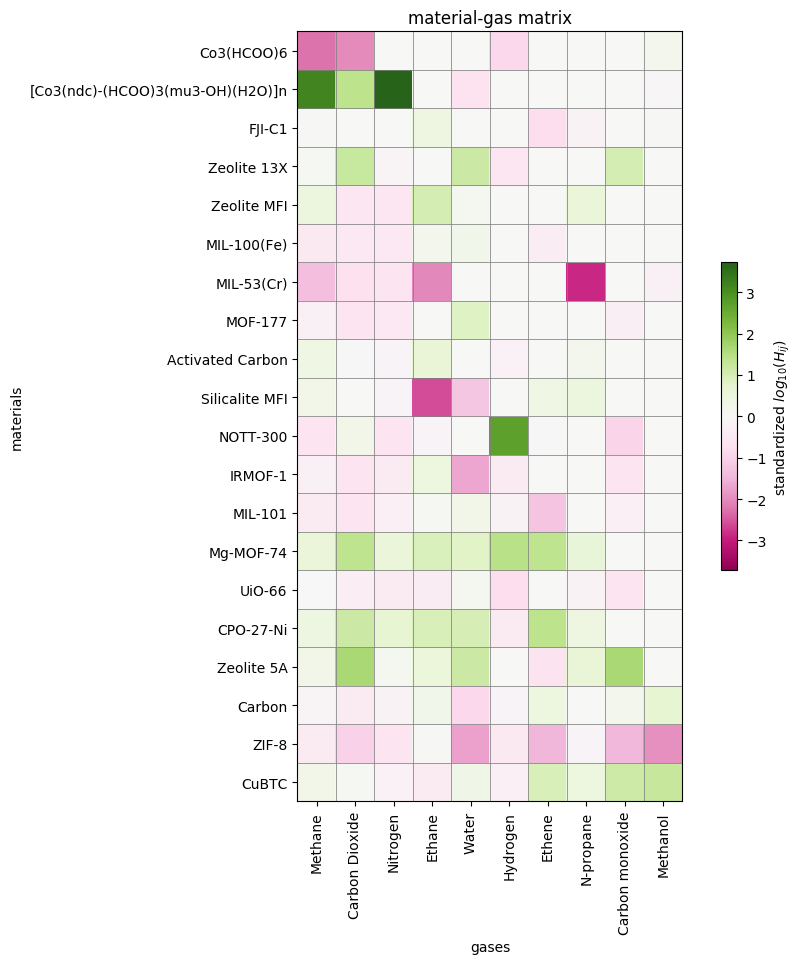

In [200]:
spy_H = deepcopy(H)
spy_H[ismissing.(H)] .= 0.0

fig, ax = subplots(figsize=(10, 10))
pcolormesh(spy_H, cmap="PiYG", 
    vmax=maximum(abs.(spy_H)), vmin=-maximum(abs.(spy_H)))
cbar = colorbar(label=L"standardized $log_{10}(H_{ij})$", shrink=0.4)
# grid lines
for x = 1:nm
    plot([0, ng], [x, x], linewidth=0.55, color="gray")
end
for y = 1:ng
    plot([y, y ], [0, nm], linewidth=0.55, color="gray")
end
ax.set_aspect("equal")
title("material-gas matrix")
xlabel("gases")
ylabel("materials")
# TODO make missing values black to distinguish between actual 0 and missing.
# TODO xticks, yticks with material and gas names
xticks(collect(1:ng) .- 0.5, gases, rotation=90)
yticks(collect(1:nm) .- 0.5, materials);

## work with `H'`, i.e. transpose of `H` to add row offsets via `LowRankModels.jl`

In [201]:
H = collect(H')

10×20 Array{Union{Missing, Float64},2}:
  0.267907  -0.423017   -0.112623  …   0.0479473   3.18877    -2.24193 
  0.065809  -1.01039    -0.388459       missing    1.4218     -1.98311 
 -0.179004  -0.63657    -0.165078       missing    3.72261      missing
 -0.390227   0.0314172   0.253896      0.389029     missing     missing
  0.317556  -1.72551    -0.889041       missing   -0.678612     missing
 -0.23617   -0.464718   -0.140357  …    missing     missing   -0.899088
  0.95998   -1.47791     0.456343     -0.777875     missing     missing
  0.447882  -0.138967     missing     -0.165328     missing     missing
  1.15451   -1.42975     0.210019       missing     missing     missing
  1.27722   -1.94111     0.702298      0.0365447  -0.0747021   0.224248

# find the optimal low rank model through cross-validation

In [202]:
ids_obs = observations(H) # returns tuple of observations
nb_obs = length(ids_obs)
println("# observations = ", nb_obs)
println("fraction entries that are filled = ", nb_obs / nm / ng)

# observations = 139
fraction entries that are filled = 0.6950000000000001


### set up generalized low rank model for practice

we'll train on all data for practice to see how it works.

TODO: ask Prof. Udell why offsets are not regularized.

In [203]:
# k = rank of matrix
# γ = regularization param
# Udell: do we need to look at ch? does it tell us if it fails?
function fit_glrm(k::Int, γ::Float64, obs::Array{Tuple{Int64,Int64},1}; verbose::Bool=true)
    rx = QuadReg(γ) # quadratic regularizer on X, Y
    ry = QuadReg(γ * ng / nm)

    glrm = GLRM(H, QuadLoss(), rx, ry, k, obs=obs, offset=true)

    X, Y, ch = fit!(glrm, verbose=verbose) # H ~ X' * Y

    @assert isapprox(impute(glrm), X' * Y)
    return X, Y, glrm, ch
end

X, Y, glrm, ch = fit_glrm(1, 30.0, ids_obs)

Fitting GLRM
Iteration 10: objective value = 70.06804056993657


([1.0 1.0 … 1.0 1.0], [0.3658887075412664 -0.9179723907668665 … 1.5132430208898435 -1.2219478657516911], GLRM(Union{Missing, Float64}[0.26790719459142637 -0.4230172207333921 … 3.1887706143512182 -2.2419303532119166; 0.06580896564715606 -1.0103928657764942 … 1.4218015455814612 -1.9831077228865475; … ; 1.154507164602901 -1.42974964173103 … missing missing; 1.2772159037191322 -1.9411064134767853 … -0.07470207376299119 0.22424845036806795], Loss[QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), Qua

### split the observations into `n_folds` folds.

TODO: ask Prof. Udell how this works when a MOF is missing from a row.

In [209]:
n_folds = nb_obs # K-fold cross validation
println("running $n_folds-cross validation...")
kfolds = KFold(nb_obs, n_folds=n_folds, shuffle=true);

running 139-cross validation...


## run cross-validation

specify the range of ranks and regularization params we aim to cover

In [214]:
ks = [1, 2, 3] # ranks
γs = 10.0 .^ range(0.0, 1.0, length=15); # regularization params

map rank to color for data visualizations

In [215]:
cmap = PyPlot.matplotlib.cm.viridis
norm = PyPlot.matplotlib.colors.Normalize(vmin=minimum(ks), vmax=maximum(ks))
rank_to_color = PyPlot.matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap).to_rgba

PyObject <bound method ScalarMappable.to_rgba of <matplotlib.cm.ScalarMappable object at 0x7f047be3c710>>

run `n_folds` cross validation, store test error for each $(k, \gamma)$ combo

In [216]:
# TODO ask Prof. Udell if it makes any sense to regularize X, Y separately

# progress meter
p = Progress(n_folds * length(ks) * length(γs))

mse = Dict(k => zeros(length(γs)) for k in ks) # store MSE for each regularization param and k

# loop over ranks
for (i_k, k) in enumerate(ks)
    # loop over regularization params
    for (i_γ, γ) in enumerate(γs)
        # loop over folds
        for (train_ids, test_ids) in kfolds
            # train model on training data
            X, Y, glrm, ch = fit_glrm(k, γ, ids_obs[train_ids], verbose=false)
            
            # assess error on test data
            Ĥ = impute(glrm)
            H_pred = [Ĥ[i, j] for (i, j) in ids_obs[test_ids]]
            H_actual = [H[i, j] for (i, j) in ids_obs[test_ids]]
            mse[k][i_γ] += sum((H_pred .- H_actual) .^ 2) / length(test_ids)
            ProgressMeter.next!(p)
        end
    end
    mse[k] /= n_folds
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:33


visualize average `n_fold` test set error against regularization param $\gamma$ for different ranks

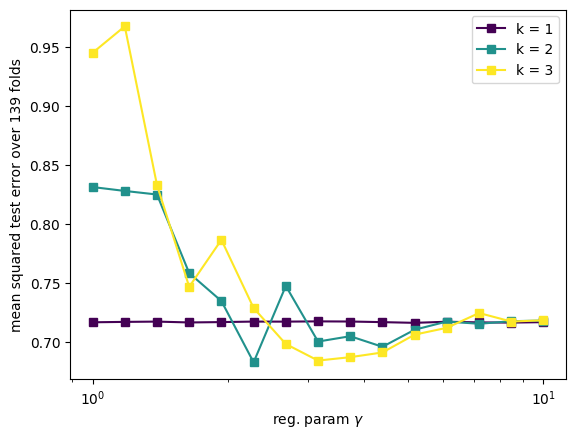

PyObject <matplotlib.legend.Legend object at 0x7f0484a659b0>

In [217]:
figure()
xlabel(L"reg. param $\gamma$")
ylabel("mean squared test error over $n_folds folds")
for k in ks
    plot(γs, mse[k], label=@sprintf("k = %d", k), marker="s", color=rank_to_color(k))
end
xscale("log")
legend()
# Udell ?: should call when we only have MOF offsets, k = 0 or k = 1?
# Udell ?: if we are not regularizing the offsets, why is k=1 fixed? do we need to change max_iter or something?

## work with optimal model

In [218]:
min_mse = [minimum(mse[k]) for k in ks]
opt_k = ks[argmin(min_mse)] # optimum rank
opt_γ = γs[argmin(mse[opt_k])]

@printf("optimum γ = %.3f, optimum k = %d\n", opt_γ, opt_k)

optimum γ = 2.276, optimum k = 2


### parity plot over `n_folds`-cross validation

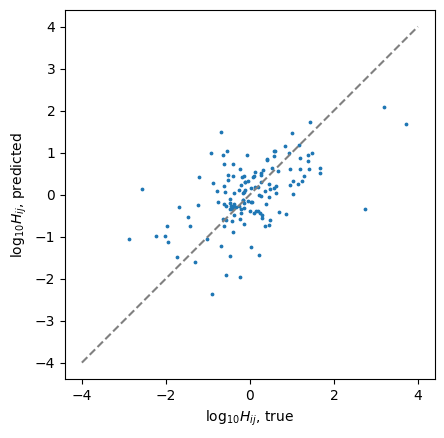

R² = 0.22803319885222773


0-element Array{Any,1}

In [222]:
H_actual = Float64[]
H_pred = Float64[]
for (train_ids, test_ids) in kfolds
    # train model on training data
    X, Y, glrm, ch = fit_glrm(opt_k, opt_γ, ids_obs[train_ids], verbose=false)
    
    # test
    Ĥ = impute(glrm)
    H_pred = vcat(H_pred, [Ĥ[i, j] for (i, j) in ids_obs[test_ids]])
    H_actual = vcat(H_actual, [H[i, j] for (i, j) in ids_obs[test_ids]])
end

R² = 1 - sum((H_pred .- H_actual) .^ 2) / sum((H_actual .- mean(H_actual)) .^ 2)
@show R²

fig, ax = subplots()
xlabel(L"$\log_{10} H_{ij}$, true")
ylabel(L"$\log_{10} H_{ij}$, predicted")
# hexbin(H_actual, H_pred, cmap="Greens", mincnt=1) #mincnt=1 makes bins white
scatter(H_actual, H_pred, s=3)
ax.set_aspect("equal")
plot([-4, 4], [-4, 4], linestyle="--", color="gray")
plot()

## viz offsets and latent space on fully trained model

In [129]:
X, Y, glrm, ch = fit_glrm(opt_k, opt_γ, ids_obs, verbose=false)

([1.0 1.0 … 1.0 1.0], [0.5528762931436484 0.10515204713581178 … 0.28956695107274033 0.15124339298207126], GLRM(Union{Missing, Float64}[0.4028549908018076 -0.1196639997731161 … missing missing; 0.39458181199194325 -0.08737542650249366 … missing missing; … ; 1.251573313754664 0.5625114750119004 … missing missing; missing missing … missing missing], Loss[QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain())  …  QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain())], Regularizer[lastentry1(QuadReg(71.96856730011521)), lastentry1

### offsets $\mu_i$ representing material biases

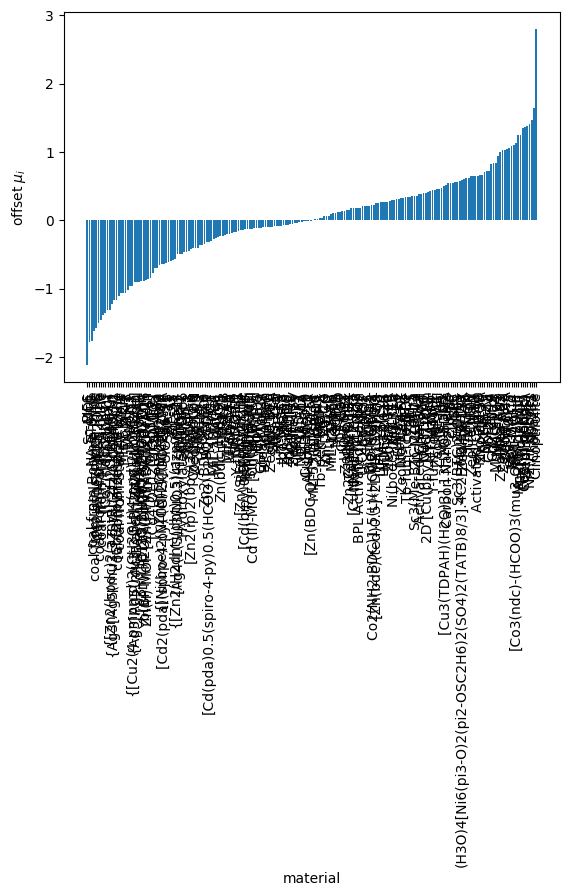

In [130]:
μ = Y[end, :]

figure()
bar(1:nm, μ[sortperm(μ)])
xlabel("material")
ylabel(L"offset $\mu_i$")
xticks(1:nm, materials[sortperm(μ)], rotation=90);

### latent space of materials